In [1]:
pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.6 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [2]:
#モジュールのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
import lightgbm as lgb

In [3]:
#データの読み込み
air_reserve = pd.read_csv("air_reserve.csv") #airシステムで行われあt予約情報
air_store_info = pd.read_csv("air_store_info.csv") #レストランに関する情報
air_visit_data = pd.read_csv("air_visit_data.csv") #レストランの過去の訪問データ
date_info = pd.read_csv("date_info.csv") #カレンダーの日付情報
hpg_reserve = pd.read_csv("hpg_reserve.csv") #hpgシステムで行われた予約情報
hpg_store_info = pd.read_csv("hpg_store_info.csv") #hpgシステムを使用しているレストラン情報
store_id_relation = pd.read_csv("store_id_relation.csv") #hpdとairのid連携
sample_sub = pd.read_csv("sample_submission.csv") #sab

In [4]:
#データの確認
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [5]:
#欠損値の確認
air_reserve.isnull().sum()

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [6]:
#datetime型に変換
print(air_reserve["visit_datetime"].dtypes)
air_reserve["visit_datetime"] = pd.to_datetime(air_reserve["visit_datetime"])
print(air_reserve["visit_datetime"].dtype) #データ型の確認

print(air_reserve["reserve_datetime"].dtypes)
air_reserve["reserve_datetime"] = pd.to_datetime(air_reserve["reserve_datetime"])
print(air_reserve["reserve_datetime"].dtype) #データ型の確認

object
datetime64[ns]
object
datetime64[ns]


In [7]:
#年月日をタイムスタンプから抽出
air_reserve["visit_date"] = air_reserve["visit_datetime"].dt.strftime('%Y-%m-%d')

In [8]:
#予約時間と来店時間との差分
air_reserve["time_lag"] = air_reserve["visit_datetime"] - air_reserve["reserve_datetime"]

In [9]:
#日付データの作成(2016-01-01~2017-05-31)
store_id = pd.DataFrame(
    {
    "air_store_id":air_reserve["air_store_id"].unique(),
    "flg":1
    }
)

data_index = pd.DataFrame(
    {
    "visit_date":pd.date_range(start= "2016-01-01", end= "2017-05-31"),
    "flg":1
    }
)
store_data_index = pd.merge(data_index,  store_id, on="flg", how="outer")

In [10]:
#データサイズ確認
air_reserve["visit_date"].unique().shape

(433,)

In [11]:
air_reserve.tail()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,time_lag
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6,2017-05-29,41 days 23:00:00
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8,2017-05-30,41 days 06:00:00
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3,2017-05-31,48 days 21:00:00
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10,2017-05-31,42 days 04:00:00
92377,air_3cad29d1a23209d2,2017-05-31 21:00:00,2017-04-22 10:00:00,3,2017-05-31,39 days 11:00:00


In [12]:
#日付ごとに集計したデータフレームを作成
air_df = air_reserve.groupby(["visit_date","air_store_id"]).agg({"reserve_visitors":"sum", "time_lag":"sum"}).reset_index()
air_df.shape

(29830, 4)

In [13]:
#確認
air_df["visit_date"].unique()

array(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
       '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
       '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12',
       '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16',
       '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20',
       '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24',
       '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
       '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01',
       '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05',
       '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09',
       '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13',
       '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17',
       '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21',
       '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25',
       '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29',
       '2016-03-01', '2016-03-02', '2016-03-03', '2016-

In [14]:
air_df["visit_date"] = pd.to_datetime(air_df["visit_date"])

In [15]:
date_info = date_info.rename(columns={"calendar_date":"visit_date"})
date_info["visit_date"] = pd.to_datetime(date_info["visit_date"])
air_visit_data["visit_date"] = pd.to_datetime(air_visit_data["visit_date"])

In [16]:
#分析用のデータを作成
print(store_data_index.shape)
air_df2 = pd.merge(store_data_index,air_df,on=["visit_date","air_store_id"],how="left")
print(air_df2.shape)
air_df3 = pd.merge(air_df2,air_store_info,on=["air_store_id"],how="left")
print(air_df3.shape)
air_df4 = pd.merge(air_df3,date_info,on=["visit_date"],how="left")
print(air_df4.shape)
air_df5 = pd.merge(air_df4,air_visit_data,on=["visit_date","air_store_id"],how="left")
print(air_df5.shape)

(162338, 3)
(162338, 5)
(162338, 9)
(162338, 11)
(162338, 12)


In [17]:
#確認
air_df5.head()

,visit_date,flg,air_store_id,reserve_visitors,time_lag,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,visitors
0,2016-01-01,1,air_877f79706adbfb06,3.0,07:00:00,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Friday,1,3.0
1,2016-01-01,1,air_db4b38ebe7a7ceff,9.0,00:00:00,Dining bar,Ōsaka-fu Ōsaka-shi Shinmachi,34.676231,135.486059,Friday,1,21.0
2,2016-01-01,1,air_db80363d35f10926,5.0,19:00:00,Dining bar,Hokkaidō Asahikawa-shi 6 Jōdōri,43.770635,142.364819,Friday,1,8.0
3,2016-01-01,1,air_3bb99a1fe0583897,NaN,NaT,Izakaya,Miyagi-ken Sendai-shi Kamisugi,38.269076,140.870403,Friday,1,NaN
4,2016-01-01,1,air_2b8b29ddfd35018e,NaN,NaT,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,Friday,1,NaN


In [18]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [19]:
hpg_reserve["visit_datetime"] = pd.to_datetime(hpg_reserve["visit_datetime"])
hpg_reserve["visit_date"] = hpg_reserve["visit_datetime"].dt.strftime('%Y-%m-%d')
hpg_reserve["reserve_datetime"] = pd.to_datetime(hpg_reserve["reserve_datetime"])
hpg_reserve["reserve_date"] = hpg_reserve["reserve_datetime"].dt.strftime('%Y-%m-%d')

In [20]:
#日付ごとに集計したデータフレームを作成
hpg_df = hpg_reserve.groupby(["reserve_date","hpg_store_id"]).agg({"reserve_visitors":"sum"}).reset_index()
hpg_df.shape

(1444616, 3)

In [21]:
hpg_df2 = pd.merge(hpg_df,store_id_relation,on="hpg_store_id",how="inner")
hpg_df2 = hpg_df2.rename(columns={"reserve_visitors":"reserve_count","reserve_date":"visit_date"})

In [22]:
hpg_df2["visit_date"] = pd.to_datetime(hpg_df2["visit_date"])

In [23]:
#HPGの予約情報を追加
air_df6 = pd.merge(air_df5, hpg_df2[["air_store_id","visit_date","reserve_count"]], on=["air_store_id","visit_date"], how="left")

In [24]:
#確認
air_df6.shape

(162338, 13)

In [25]:
#欠損値確認
air_df6.isnull().sum()

visit_date               0
flg                      0
air_store_id             0
reserve_visitors    132508
time_lag            132508
air_genre_name           0
air_area_name            0
latitude                 0
longitude                0
day_of_week              0
holiday_flg              0
visitors             65005
reserve_count       143945
dtype: int64

In [26]:
#欠損している値は０で補完
air_df6 = air_df6.drop("time_lag",axis=1)
air_df6 = air_df6.fillna(0)

In [27]:
air_df6 = air_df6.rename(columns={"reserve_visitors":"visit_count"})

###来店回数、予約回数の確認

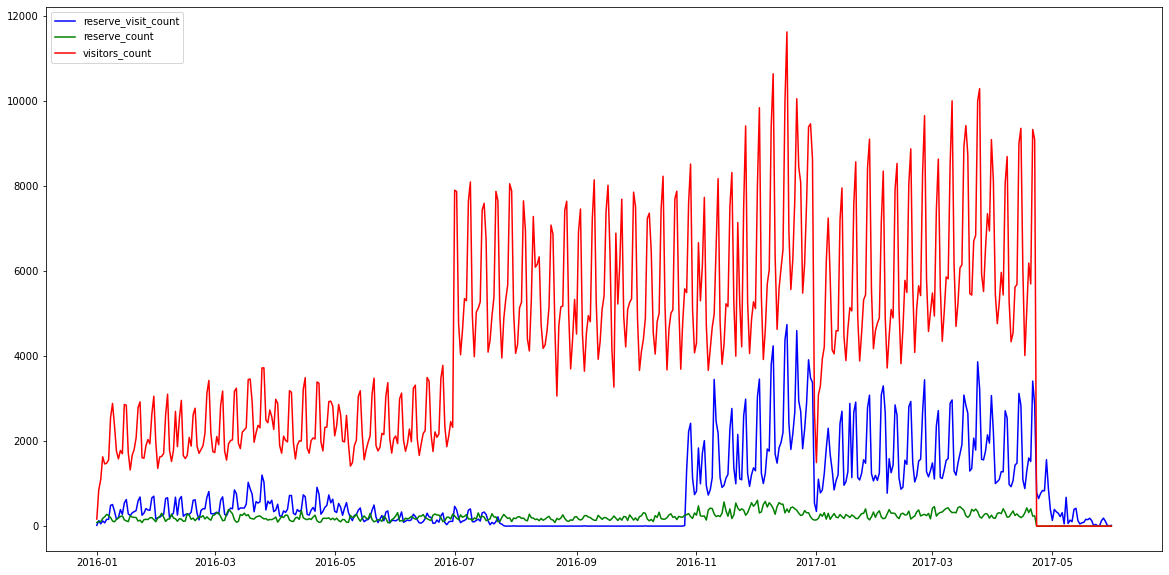

In [28]:
#1日当たりの来店回数、予約回数を集計し可視化
total = air_df6.groupby("visit_date").agg({"visit_count":"sum","reserve_count":"sum"}).reset_index()
visit_total = air_df6.groupby("visit_date").agg({"visitors":"sum"}).reset_index()

plt.figure(figsize=(20,10))

c1,c2,c3 = "blue","green","red"  
l1,l2,l3 = "reserve_visit_count","reserve_count","visitors_count" 

plt.plot(total["visit_date"], total["visit_count"], color=c1, label=l1) #airシステムからの予約数
plt.plot(total["visit_date"], total["reserve_count"], color=c2, label=l2) #hpgからの予約数
plt.plot(visit_total["visit_date"], visit_total["visitors"], color=c3, label=l3) #来店回数

plt.legend(loc=2)

plt.show()

2016-05から201608までairシステムからの予約件数が減少。2016-08から2016-11までairシステムからの予約件数はほとんど０となっている。
2016-11から大幅にairシステムの予約件数が増加している。
hpgからの予約件数は大きな変化はなく一定の推移となっている。

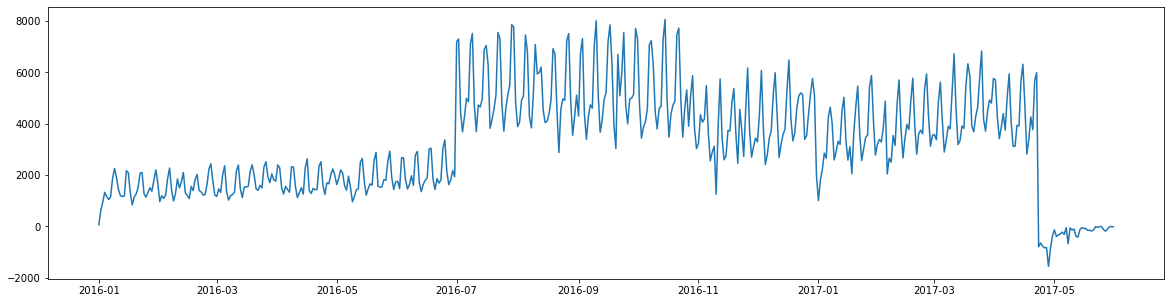

In [29]:
air_df6["lag"] = air_df6["visitors"] - air_df6["visit_count"] - air_df6["reserve_count"]
lag_total = air_df6.groupby("visit_date").agg({"lag":"sum"}).reset_index()

plt.figure(figsize=(20,5))
plt.plot(lag_total["visit_date"], lag_total["lag"])
plt.show()

①2016-07までは差分が2000だが、②2016-07から2016-10までは6000、③2016-11以降からは6000と期間ごとに差分でグループに分けられる。
このことから今後の来店回数を予測する場合は2016-11以降からのデータを使用した方が精度が高くなると考えられる。
（①を入れると来店回数が低く出そうだし、②は逆に高く出てきそう）

In [30]:
#相関係数を確認
air_df6.corr()

,flg,visit_count,latitude,longitude,holiday_flg,visitors,reserve_count,lag
flg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visit_count,NaN,1.000000,2.616296e-02,-1.876640e-02,-5.888942e-03,0.275429,0.027062,-0.381154
latitude,NaN,0.026163,1.000000e+00,6.640243e-01,-2.043963e-17,-0.022525,0.009702,-0.039831
longitude,NaN,-0.018766,6.640243e-01,1.000000e+00,3.348707e-18,-0.028044,-0.047204,-0.007315
holiday_flg,NaN,-0.005889,-2.043963e-17,3.348707e-18,1.000000e+00,-0.030125,-0.018681,-0.022075
visitors,NaN,0.275429,-2.252519e-02,-2.804382e-02,-3.012493e-02,1.000000,0.058816,0.770636
reserve_count,NaN,0.027062,9.702051e-03,-4.720398e-02,-1.868074e-02,0.058816,1.000000,-0.119728
lag,NaN,-0.381154,-3.983134e-02,-7.314533e-03,-2.207476e-02,0.770636,-0.119728,1.000000


visitorsとの相関係数を確認すると、visit_countはとても弱い正の相関、reserve_countは相関がない
lagはvisitorsの値を使用しているため相関係数が高く出ているが特徴量としては使用ができない

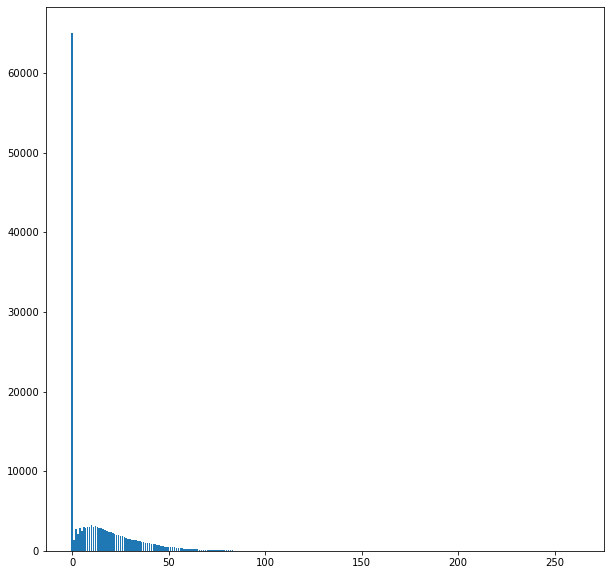

In [31]:
#来店回数の分布
kensyou = air_df6.groupby("visitors").count().reset_index()
plt.figure(figsize=(10,10))
plt.bar(kensyou["visitors"],kensyou["flg"])
plt.show()

In [32]:
#年月をタイムスタンプから抽出
air_df6["year_month"] = air_df6["visit_date"].dt.strftime('%Y-%m')

In [33]:
#2016-11以降のデータで来店回数を計算
air_df7 = air_df6[air_df6["year_month"] >= "2016-11"]

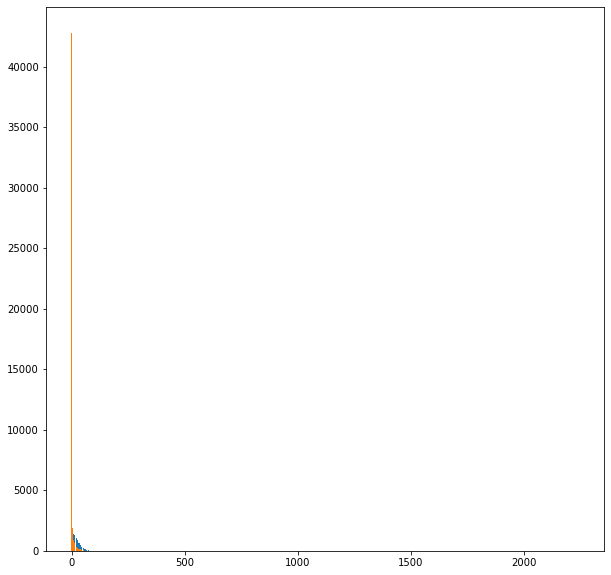

In [34]:
#来店回数の分布
kensyou = air_df7.groupby("visitors").count().reset_index()
kensyou_2 = air_df7.groupby("visit_count").count().reset_index()
plt.figure(figsize=(10,10))
plt.bar(kensyou["visitors"],kensyou["flg"])
plt.bar(kensyou_2["visit_count"],kensyou_2["flg"])
plt.show()

来店回数の分布を見るとほとんどが0回であり、その後若干増加し右に裾が長い分布となっていることから負の二項分布に近い分布にあたると考えられる。
airの予約件数はほとんどが０であり山もないことからポアソン分布に従っているように見える。

In [35]:
#曜日ごとの平均来店回数
air_df6.groupby("day_of_week").agg({"visitors":"mean","visit_count":"mean"})

,visitors,visit_count
day_of_week,,
Friday,17.712730,3.983689
Monday,9.462085,1.552117
Saturday,18.794586,3.956920
Sunday,11.895335,1.877475
Thursday,12.532763,2.379286
Tuesday,10.937296,1.847908
Wednesday,12.514546,2.252582


In [36]:
#曜日ごとの平均来店回数
air_df7.groupby("day_of_week").agg({"visitors":"mean","visit_count":"mean"})

,visitors,visit_count
day_of_week,,
Friday,21.603715,7.931423
Monday,11.082378,3.095223
Saturday,23.196178,7.764437
Sunday,13.935669,3.732909
Thursday,15.333015,4.768259
Tuesday,12.993220,3.619684
Wednesday,14.949353,4.463324


曜日ごとの平均回数を見るとfriday、Saturdayの平均来店回数が多い。
翌日が休みとなる週末に集中していると考えられる。
日月火＜水木＜金土といった傾向がある。
2016-11以降は約２倍の予約が入っている。

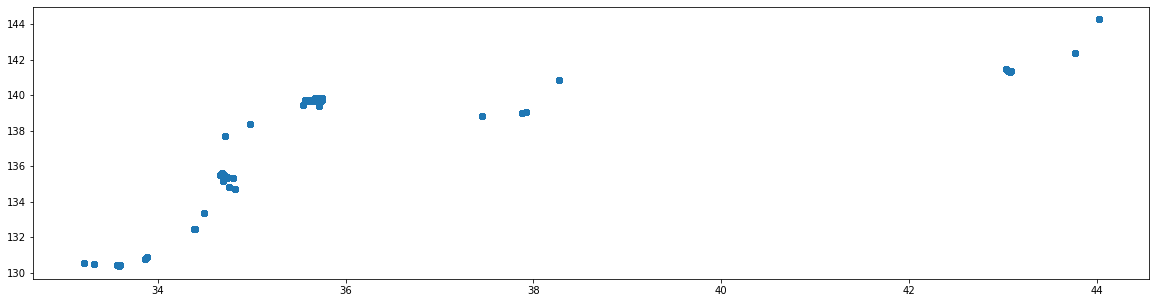

In [37]:
#緯度経度を散布図で表してみる
plt.figure(figsize=(20,5))
plt.scatter(air_df7["latitude"],air_df7["longitude"])

経度35,36あたりが比較的多い
経度から九州から北海道までカバーしていることがわかった
駅からの距離を測りたかったが全国のオープンデータが見つからなかったため断念

In [38]:
air_df7.head()

,visit_date,flg,air_store_id,visit_count,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,visitors,reserve_count,lag,year_month
95770,2016-11-01,1,air_877f79706adbfb06,10.0,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tuesday,0,10.0,0.0,0.0,2016-11
95771,2016-11-01,1,air_db4b38ebe7a7ceff,2.0,Dining bar,Ōsaka-fu Ōsaka-shi Shinmachi,34.676231,135.486059,Tuesday,0,4.0,0.0,2.0,2016-11
95772,2016-11-01,1,air_db80363d35f10926,0.0,Dining bar,Hokkaidō Asahikawa-shi 6 Jōdōri,43.770635,142.364819,Tuesday,0,0.0,3.0,-3.0,2016-11
95773,2016-11-01,1,air_3bb99a1fe0583897,7.0,Izakaya,Miyagi-ken Sendai-shi Kamisugi,38.269076,140.870403,Tuesday,0,14.0,0.0,7.0,2016-11
95774,2016-11-01,1,air_2b8b29ddfd35018e,0.0,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,Tuesday,0,13.0,2.0,11.0,2016-11


In [39]:
#飲食店の種類別平均来店回数
air_df7.groupby("air_genre_name").agg({"visitors":"mean","visit_count":"mean"}).reset_index().sort_values("visitors")

,air_genre_name,visitors,visit_count
5,International cuisine,8.235849,0.066038
1,Bar/Cocktail,8.976078,1.938005
8,Japanese food,12.848731,4.872967
11,Other,13.149371,3.537736
6,Italian/French,15.417839,5.667839
10,Okonomiyaki/Monja/Teppanyaki,16.276205,4.740042
4,Dining bar,16.548298,4.113413
13,Yakiniku/Korean food,16.664465,6.050000
2,Cafe/Sweets,16.866981,2.585142
12,Western food,17.106469,7.671833


karaoke/partyが平均客数、平均予約数共に一番多い
Asian、international cuisineは予約がほとんどない

In [40]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,time_lag
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,03:00:00
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,00:00:00
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,00:00:00
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,04:00:00
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,19:00:00


In [41]:
#年月日をタイムスタンプから抽出
air_reserve["hour"] = air_reserve["visit_datetime"].dt.strftime('%H')

<BarContainer object of 24 artists>

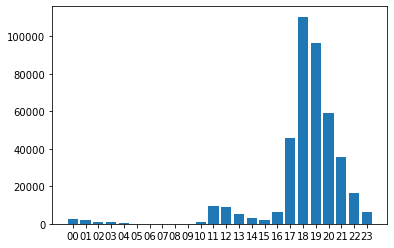

In [42]:
total_hour = air_reserve.groupby("hour")["reserve_visitors"].sum().reset_index()
plt.bar(total_hour["hour"],total_hour["reserve_visitors"])

In [43]:
air_df7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66568 entries, 95770 to 162337
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   visit_date      66568 non-null  datetime64[ns]
 1   flg             66568 non-null  int64         
 2   air_store_id    66568 non-null  object        
 3   visit_count     66568 non-null  float64       
 4   air_genre_name  66568 non-null  object        
 5   air_area_name   66568 non-null  object        
 6   latitude        66568 non-null  float64       
 7   longitude       66568 non-null  float64       
 8   day_of_week     66568 non-null  object        
 9   holiday_flg     66568 non-null  int64         
 10  visitors        66568 non-null  float64       
 11  reserve_count   66568 non-null  float64       
 12  lag             66568 non-null  float64       
 13  year_month      66568 non-null  object        
dtypes: datetime64[ns](1), float64(6), int64(2), objec

In [44]:
#県を抽出
air_df7["area"] = air_df7["air_area_name"].str.split("-",expand=True)[0]
air_df7 = air_df7.drop("air_area_name",axis=1)

<ipython-input-44-b00f39fdb8af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_df7["area"] = air_df7["air_area_name"].str.split("-",expand=True)[0]


In [45]:
#object型をcategory型へ変換
for i in ["air_store_id", "air_genre_name", "day_of_week", "area"]:
    air_df7[i] = air_df7[i].astype("category")

In [46]:
#year_monthを削除
air_df7 = air_df7.drop("year_month", axis=1)

In [47]:
#2016-11から2017-01までのデータを用いて2017-02の予測をしてみる(train)
X_train = air_df7[air_df7["visit_date"] <= "2017-01"].drop("visitors",axis=1)
y_train = air_df7[air_df7["visit_date"] <= "2017-01"]["visitors"]

In [48]:
#2016-11から2017-02までのデータを用いて2017-03を予測（val）
X_val = air_df7[air_df7["visit_date"] <= "2017-02"].drop("visitors",axis=1)
y_val = air_df7[air_df7["visit_date"] <= "2017-02"]["visitors"]

In [49]:
#visit_dateをcategory型へ変換
X_train["visit_date"] = X_train["visit_date"].astype("int")
X_val["visit_date"] = X_val["visit_date"].astype("int")

In [53]:
#テストデータ作成
x_test = air_df7[air_df7["visit_date"] == "2017-02"].drop("visitors",axis=1)
y_test = air_df7[air_df7["visit_date"] == "2017-02"]["visitors"]
x_test2 = air_df7[air_df7["visit_date"] == "2017-03"].drop("visitors",axis=1)
y_test2 = air_df7[air_df7["visit_date"] == "2017-03"]["visitors"]

In [57]:
#visit_dateをcategory型へ変換
x_test["visit_date"] = x_test["visit_date"].astype("int")
x_test2["visit_date"] = x_test2["visit_date"].astype("int")

In [50]:
#モデル定義
model = lgb.LGBMRegressor(learning_rate=0.1,metrics='rmse',max_depth=12,num_leaves=25)
#学習
model.fit(X_train,y_train)

LGBMRegressor(max_depth=12, metrics='rmse', num_leaves=25)

In [54]:
#評価指標
from sklearn.metrics import mean_squared_error
from math import sqrt
y_pred = model.predict(X_train)
rmse = sqrt(mean_squared_error(y_train, y_pred))
print("rmse.train_score:{}".format(rmse))

y_pred_val = model.predict(X_val)
rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
print("rmse.val_score:{}".format(rmse_val))

rmse.train_score:1.0575952065685825
rmse.val_score:0.99370031904583


In [59]:
#テスト
y_pred = model.predict(x_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print("rmse.train_score:{}".format(rmse))

y_pred_val = model.predict(x_test2)
rmse_val = sqrt(mean_squared_error(y_test2, y_pred_val))
print("rmse.val_score:{}".format(rmse_val))

rmse.train_score:0.47649823080426357
rmse.val_score:0.5445653855285624


In [60]:
#モデル定義 tweedie
model_2 = lgb.LGBMRegressor(learning_rate=0.1,metrics='tweedie',max_depth=12,num_leaves=25)
#学習
model_2.fit(X_train,y_train)

LGBMRegressor(max_depth=12, metrics='tweedie', num_leaves=25)

In [61]:
y_pred_tweedie = model_2.predict(X_train)
tweedie = sqrt(mean_squared_error(y_train, y_pred_tweedie))
print("rmse.train_score:{}".format(tweedie))

y_pred_val_tweedie = model_2.predict(X_val)
tweedie_val = sqrt(mean_squared_error(y_val, y_pred_val_tweedie))
print("rmse.val_score:{}".format(tweedie_val))

rmse.train_score:1.0575952065685825
rmse.val_score:0.99370031904583


In [62]:
#テスト
y_pred_tweedie = model_2.predict(x_test)
tweedie = sqrt(mean_squared_error(y_test, y_pred_tweedie))
print("tweedie.train_score:{}".format(tweedie))

y_pred_val_tweedie = model_2.predict(x_test2)
tweedie_val = sqrt(mean_squared_error(y_test2, y_pred_val_tweedie))
print("rmse.val_score:{}".format(tweedie_val))

tweedie.train_score:0.47649823080426357
rmse.val_score:0.5445653855285624
